# GGA 二阶 CP-HF 方程

这份笔记我们讨论 GGA 的二阶 CP-HF 方程．在这里我们不区分 CP-HF 与 CP-KS，就统称为 CP-HF 方程．

对于非自洽 DFT 泛函的 Hessian 而言，我们需要在自洽泛函求解的项的基础上，额外地再引入二阶 CP-HF 方程的求解．在此之前，我们已经了解了 HF 方法的二阶 CP-HF 方程求解．求解 HF 方程的最困难之处在于 $B_{ai}^{A_t B_s}$ 的求解；尽管我们可以利用大多数在求 $U_{pq}^{A_t}$ 时所计算的项，但 $F_{\mu \nu}^{A_t B_s}$ 与 $A_{pq, rs}^{A_t}$ 两项是需要额外计算的．

尽管总得来看，GGA 与 HF 在处理二阶 CP-HF 方程时，所需要计算的表达式 ($B_{ai}^{A_t B_s}$) 大体分项完全相同；但具体到求 $F_{\mu \nu}^{A_t B_s}$ 与 $A_{pq, rs}^{A_t}$ 时，问题会比 HF 方法复杂许多．我们这一节所需要解决的主要问题仅仅就是求出 GGA 下的 $F_{\mu \nu}^{A_t B_s}$ 与 $A_{pq, rs}^{A_t}$．在获得这两项后，我们代入非自洽 Hessian 框架，应当能很快地与 HF-GGA 一样，求出非自洽 GGA-GGA 的能量 Hessian．

In [145]:
import numpy as np
from pyscf import scf, gto, lib, grad, hessian, dft
import pyscf.hessian.rks
import pyscf.grad.rks
from functools import partial
from hf_helper import HFHelper
from gga_helper import GGAHelper
from grid_helper import GridHelper, KernelHelper
from numeric_helper import NumericDiff
from ncgga_engine import NCGGAEngine
import pickle
import matplotlib.pyplot as plt

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.einsum_path = partial(np.einsum_path, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(5, linewidth=120, suppress=True)

In [24]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.5  0.0  0.0
H  0.0  0.7  1.5
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

# This document is somehow computation prohibitive
# So using coarse (75, 302) grid, just addressing main idea without waiting
grids = dft.gen_grid.Grids(mol)
grids.atom_grid = (75, 302)
grids.becke_scheme = dft.gen_grid.stratmann
grids.build()

nmo = nao = mol.nao
natm = mol.natm
nocc = mol.nelec[0]
nvir = nmo - nocc
so = slice(0, nocc)
sv = slice(nocc, nmo)
sa = slice(0, nmo)

In [48]:
ggah = GGAHelper(mol, "b3lypg", grids, init_scf=True)
cx       = ggah.cx
ggah.get_grad()
ggah.get_hess()
scf_eng  = ggah.scf_eng
scf_grad = ggah.scf_grad
scf_hess = ggah.scf_hess
C        = ggah.C
Co       = ggah.Co
Cv       = ggah.Cv
e        = ggah.e
eo       = ggah.eo
ev       = ggah.ev
D        = ggah.D
F_0_ao   = ggah.F_0_ao
F_0_mo   = ggah.F_0_mo
H_0_ao   = ggah.H_0_ao
H_0_mo   = ggah.H_0_mo
eri0_ao  = ggah.eri0_ao
eri0_mo  = ggah.eri0_mo
mo_occ   = ggah.mo_occ
H_1_ao   = ggah.H_1_ao
H_1_mo   = ggah.H_1_mo
S_1_ao   = ggah.S_1_ao
S_1_mo   = ggah.S_1_mo
F_1_ao   = ggah.F_1_ao
F_1_mo   = ggah.F_1_mo
eri1_ao  = ggah.eri1_ao
H_2_ao   = ggah.H_2_ao
H_2_mo   = ggah.H_2_mo
S_2_ao   = ggah.S_2_ao
S_2_mo   = ggah.S_2_mo
eri2_ao  = ggah.eri2_ao
B_1      = ggah.B_1
U_1      = ggah.U_1
Xi_2     = ggah.Xi_2
Ax0_Core = ggah.Ax0_Core
Ax1_Core = ggah.Ax1_Core
mol_slice = ggah.mol_slice

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:221: UserWarning: eri0_ao: ERI should not be stored in memory! Consider J/K engines!
  warnings.warn("eri0_ao: ERI should not be stored in memory! Consider J/K engines!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:228: UserWarning: eri0_mo: ERI AO -> MO is quite expensive!
  warnings.warn("eri0_mo: ERI AO -> MO is quite expensive!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:271: UserWarning: eri1_ao: 4-idx tensor ERI should be not used!
  warnings.warn("eri1_ao: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:309: UserWarning: eri2_ao: 4-idx tensor ERI should be not used!
  warnings.warn("eri2_ao: 4-idx tensor ERI should be not used!")
/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:365: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: 

由于默认情况下，泛函的交换相关势泛函核的导数被定为二阶；但由于当前的任务需要三阶的泛函核导数，因此需要手动使用 KernelHelper 类生成泛函核导数的格点．

In [47]:
grdh = GridHelper(mol, grids, D)
kerh = KernelHelper(grdh, "b3lypg", deriv=3)

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/grid_helper.py:18: UserWarning: GridHelper is considered memory consuming!
  warnings.warn("GridHelper is considered memory consuming!")


## 数值方法与 GGAHelper 获得二阶 U 矩阵

我们先通过数值方法与 GGAHelper 获得二阶 U 矩阵 $U_{ai}^{A_t B_s}$，以验证二阶 U 矩阵生成的正确性．

由于生成数值的二阶 U 矩阵耗时较长，我们预先计算好该矩阵，并储存到文件中了．数值的二阶 U 矩阵储存在变量 `U_2_vo_num`，而解析的二阶 U 矩阵储存在 `U_2_vo`．

In [49]:
%%time
with open("include/gga_cp2/H2O2-GGA-CP2/num_U1_U2.dat", "rb") as f:
    U_2_vo_num = pickle.load(f)["U_2_vo_num"]
U_2_vo = ggah.U_2_vo

/share/home/zyzhu/Documents-Shared/HF_DFT_related/src/hf_helper.py:365: UserWarning: U_1: Generating total U matrix should be considered as numerical unstable!
  warnings.warn("U_1: Generating total U matrix should be considered as numerical unstable!")


CPU times: user 31min 45s, sys: 39.2 s, total: 32min 24s
Wall time: 2min 13s


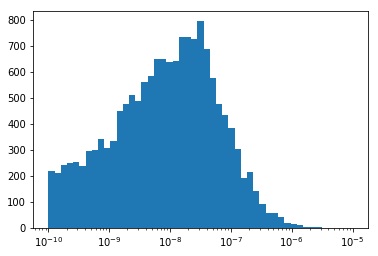

In [50]:
plt.hist(abs(U_2_vo - U_2_vo_num).ravel(), bins=np.logspace(np.log10(1e-10),np.log10(1e-5), 50))
plt.gca().set_xscale("log")

在后文中，我们将以后者作为参照值进行文档正确性的比对．

## GGA Fock 矩阵二阶 Skeleton 导数 $F_{\mu \nu}^{A_t B_s}$

### 初步回顾

该式可以被确定地定义为

$$
F_{\mu \nu}^{A_t B_s} = \partial_{B_s} F_{\mu \nu}^{A_t}
$$

我们先作一些简单的回顾．首先，我们指出从 Fock 矩阵本身的定义上，它还需要通过代入的密度来确定，即应当要写为 $F_{\mu \nu}^{A_t B_s} [X_{\kappa \lambda}]$ 的形式；但目前使用到 Fock 矩阵二阶导数的情形只在 $X_{\kappa \lambda}$ 等价于自洽场密度 $D_{\kappa \lambda}$，因此后文的 $F_{\mu \nu}^{A_t B_s}$ 一律指代的是 $F_{\mu \nu}^{A_t B_s} [D_{\kappa \lambda}]$．

Fock 矩阵可以分为 HF 部分贡献与 GGA 部分贡献．下式中，前三项为 HF 贡献，而最后一项为 GGA 贡献．

$$
F_{\mu \nu}^{A_t B_s} = h_{\mu \nu}^{A_t B_s} + (\mu \nu | \kappa \lambda)^{A_t B_s} D_{\kappa \lambda} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda)^{A_t B_s} D_{\kappa \lambda} + v_{\mu \nu}^{\mathrm{xc}, A_t B_s}
$$

HF 部分的贡献可以借用作为 GGAHelper 的基类的 HFHelper 的函数来生成：

In [34]:
F_2_ao_HF_contrib = ggah.H_2_ao + ggah.F_2_ao_Jcontrib - 0.5 * cx * ggah.F_2_ao_Kcontrib

其生成原理已经在 HF 部分叙述了，这里就不再多作说明．我们的主要任务是求取其 GGA 部分．

### GGA 一阶 Skeleton 导数回顾

随后我们回顾 GGA 部分的一阶 Skeleton 导数．我们曾经将 GGA 的一阶梯度写作

\begin{align}
%%
v_{\mu \nu}^{\mathrm{xc}, A_t} &=
\frac{1}{2} f_{\rho \rho} \rho^{A_t} \cdot \phi_\mu \phi_\nu
+ f_{\rho \gamma} \rho_w \rho_w^{A_t} \phi_\mu \phi_\nu
+ 2 f_{\rho \gamma} \rho^{A_t} \rho_r \phi_{r \mu} \phi_{\nu}
+ 4 f_{\gamma \gamma} \rho_w \rho_w^{A_t} \rho_r \phi_{r \mu} \phi_{\nu}
+ 2 f_\gamma \rho_r^{A_t} \cdot \phi_{r \mu} \phi_{\nu}
%
\\ &\quad \mathrel-
f_\rho \phi_{t \mu_A} \phi_\nu
- 2 f_\gamma \rho_r \phi_{tr \mu_A} \phi_{\nu}
- 2 f_\gamma \rho_r \phi_{t \mu_A} \phi_{r \nu}
\\ &\quad \mathrel+
\mathrm{interchange} (\mu, \nu)
\end{align}

但这种写法在推导二阶 Skeleton 导数时，会变得非常繁琐．我们下面重新回顾这个梯度的推导过程，以更连贯地推导二阶 Skeleton 导数．

首先，Fock 矩阵可以写为

\begin{align}
v_{\mu \nu}^{\mathrm{xc}} =
&+ \frac{1}{2} f_{\rho} \phi_{\mu} \phi_{\nu}
\\&+ 2 f_{\gamma} \rho_r \phi_{r \mu} \phi_{\nu}
\\&+ \mathrm{interchange}(\mu, \nu)
\end{align}

其 Skeleton 导数可以分为两部分：

* 对密度、密度梯度、以及泛函核进行的导数．这部分导数可以预先生成，并且在求和时不需要引入对原子轨道的分割 (slice).

* 对原子轨道的导数．这部分需要在求和是引入对原子轨道的分割，并且需要利用 $\mu, \nu$ 的对称性来简化程序，因此稍麻烦一些．

第一部分可以写为

\begin{align}
v_{\mu \nu}^{\mathrm{xc}, A_t} \leftarrow
&+ \frac{1}{2} (\partial_{A_t} f_{\rho}) \phi_{\mu} \phi_{\nu}
\\&+ 2 (\partial_{A_t} f_{\gamma}) \rho_r \phi_{r \mu} \phi_{\nu}
\\&+ 2 f_{\gamma} (\partial_{A_t} \rho_r) \phi_{r \mu} \phi_{\nu}
\\&+ \mathrm{interchange}(\mu, \nu)
\end{align}

我们暂时不再展开上式，但将上述出现的导数进行打包处理．因此，我们定义下述变量：

* `pd_fr`: $\partial_{A_t} f_\rho = f_{\rho \rho} \rho^{A_t} + f_{\rho \gamma} \gamma^{A_t}$

* `pd_fg`: $\partial_{A_t} f_\gamma = f_{\rho \gamma} \rho^{A_t} + f_{\gamma \gamma} \gamma^{A_t}$

* `pd_rho_1`: $\partial_{A_t} \rho_r = \rho_r^{A_t}$

In [51]:
pd_fr = kerh.frr * grdh.A_rho_1 + kerh.frg * grdh.A_gamma_1
pd_fg = kerh.frg * grdh.A_rho_1 + kerh.fgg * grdh.A_gamma_1
pd_rho_1 = grdh.A_rho_2
F_1_ao_GGA_contrib1 = (
    + 0.5 * np.einsum("Atg, gu, gv -> Atuv", pd_fr, grdh.ao_0, grdh.ao_0)
    + 2 * np.einsum("Atg, rg, rgu, gv -> Atuv", pd_fg, grdh.rho_1, grdh.ao_1, grdh.ao_0)
    + 2 * np.einsum("g, Atrg, rgu, gv -> Atuv", kerh.fg, pd_rho_1, grdh.ao_1, grdh.ao_0)
)
F_1_ao_GGA_contrib1 += F_1_ao_GGA_contrib1.swapaxes(-1, -2)

第二部分可以写为

\begin{align}
v_{\mu \nu}^{\mathrm{xc}, A_t} \leftarrow
&+ f_{\rho} \phi_{\mu}^{A_t} \phi_{\nu}
\\&+ 2 f_{\gamma} \rho_r (\phi_{r \mu}^{A_t} \phi_{\nu} + \phi_{\mu}^{A_t}\phi_{r \nu})
\\&+ \mathrm{interchange}(\mu, \nu)
\end{align}

需要注意到 $\phi_{\mu}^{A_t} = - \phi_{t \mu_A}$，因此下面的程序中会有很多负号：

In [52]:
tmp_contrib = (
    - np.einsum("g, tgu, gv -> tuv", kerh.fr, grdh.ao_1, grdh.ao_0)
    - 2 * np.einsum("g, rg, tgu, rgv -> tuv", kerh.fg, grdh.rho_1, grdh.ao_1, grdh.ao_1)
    - 2 * np.einsum("g, rg, trgu, gv -> tuv", kerh.fg, grdh.rho_1, grdh.ao_2, grdh.ao_0)
)
F_1_ao_GGA_contrib2 = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    F_1_ao_GGA_contrib2[A, :, sA] += tmp_contrib[:, sA]
F_1_ao_GGA_contrib2 += F_1_ao_GGA_contrib2.swapaxes(-1, -2)

最终，我们将这两者加和，并且加上 HF 部分的贡献，即是总的 Fock 矩阵一阶 Skeleton 导数了：

In [53]:
np.allclose(
    + H_1_ao
    + np.einsum("Atuvkl, kl -> Atuv", eri1_ao, D)
    - 0.5 * ggah.cx * np.einsum("Atukvl, kl -> Atuv", eri1_ao, D)
    + F_1_ao_GGA_contrib1 + F_1_ao_GGA_contrib2,
    F_1_ao
)

True

### GGA 二阶 Skeleton 导数

因此，仿照一阶 Skeleton 导数，我们可以将 GGA 的二阶 Skeleton 导数拆分为三部分：

* 对密度、密度梯度、以及泛函核进行的二阶导数

* 对原子轨道的一阶导数，以及对密度、密度梯度、以及泛函核进行的一阶导数

* 对原子轨道的二阶导数

**第一部分**

\begin{align}
v_{\mu \nu}^{\mathrm{xc}, A_t B_s} \leftarrow
&+ \frac{1}{2}  (\partial_{B_s} \partial_{A_t} f_{\rho}) \phi_{\mu} \phi_{\nu}
\\&+ 2  (\partial_{B_s} \partial_{A_t} f_{\gamma}) \rho_r \phi_{r \mu} \phi_{\nu}
\\&+ 2 (\partial_{A_t} f_{\gamma}) (\partial_{B_s} \rho_r) \phi_{r \mu} \phi_{\nu}
\\&+ 2 (\partial_{B_s} f_{\gamma}) (\partial_{A_t} \rho_r) \phi_{r \mu} \phi_{\nu}
\\&+ 2 f_{\gamma} (\partial_{B_s} \partial_{A_t} \rho_r) \phi_{r \mu} \phi_{\nu}
\\&+ \mathrm{interchange}(\mu, \nu)
\end{align}

其中，对泛函核的二阶导数可以展开为

\begin{align}
\partial_{B_s} \partial_{A_t} f_{\rho} &= \partial_{B_s} (f_{\rho \rho} \rho^{A_t} + f_{\rho \gamma} \gamma^{A_t}) \\
&= (\partial_{B_s} f_{\rho \rho}) \rho^{A_t} + (\partial_{B_s} f_{\rho \gamma}) \gamma^{A_t} + f_{\rho \rho} \rho^{A_t B_s} + f_{\rho \gamma} \gamma^{A_t B_s}
\end{align}

\begin{align}
\partial_{B_s} \partial_{A_t} f_{\gamma} &= \partial_{B_s} (f_{\rho \gamma} \rho^{A_t} + f_{\gamma \gamma} \gamma^{A_t}) \\
&= (\partial_{B_s} f_{\rho \gamma}) \rho^{A_t} + (\partial_{B_s} f_{\gamma \gamma}) \gamma^{A_t} + f_{\rho \gamma} \rho^{A_t B_s} + f_{\gamma \gamma} \gamma^{A_t B_s}
\end{align}

因此，我们对新出现的变量作如下的定义：

* `pd_frr`: $\partial_{A_t} f_{\rho \rho} = f_{\rho \rho \rho} \rho^{A_t} + f_{\rho \rho \gamma} \gamma^{A_t}$

* `pd_frg`: $\partial_{A_t} f_{\rho \gamma} = f_{\rho \rho \gamma} \rho^{A_t} + f_{\rho \gamma \gamma} \gamma^{A_t}$

* `pd_fgg`: $\partial_{A_t} f_{\gamma \gamma} = f_{\rho \gamma \gamma} \rho^{A_t} + f_{\gamma \gamma \gamma} \gamma^{A_t}$

* `pdpd_fr`: $\partial_{B_s} \partial_{A_t} f_{\rho} = (\partial_{B_s} f_{\rho \rho}) \rho^{A_t} + (\partial_{B_s} f_{\rho \gamma}) \gamma^{A_t} + f_{\rho \rho} \rho^{A_t B_s} + f_{\rho \gamma} \gamma^{A_t B_s}$

* `pdpd_fg`: $\partial_{B_s} \partial_{A_t} f_{\gamma} = (\partial_{B_s} f_{\rho \gamma}) \rho^{A_t} + (\partial_{B_s} f_{\gamma \gamma}) \gamma^{A_t} + f_{\rho \gamma} \rho^{A_t B_s} + f_{\gamma \gamma} \gamma^{A_t B_s}$

* `pdpd_rho_1`: $\partial_{B_s} \partial_{A_t} \rho_r = \rho_r^{A_t B_s}$

In [54]:
pd_frr = kerh.frrr * grdh.A_rho_1 + kerh.frrg * grdh.A_gamma_1
pd_frg = kerh.frrg * grdh.A_rho_1 + kerh.frgg * grdh.A_gamma_1
pd_fgg = kerh.frgg * grdh.A_rho_1 + kerh.fggg * grdh.A_gamma_1
pdpd_fr = (
    + np.einsum("Bsg, Atg -> ABtsg", pd_frr, grdh.A_rho_1)
    + np.einsum("Bsg, Atg -> ABtsg", pd_frg, grdh.A_gamma_1)
    + kerh.frr * grdh.AB_rho_2 + kerh.frg * grdh.AB_gamma_2
)
pdpd_fg = (
    + np.einsum("Bsg, Atg -> ABtsg", pd_frg, grdh.A_rho_1)
    + np.einsum("Bsg, Atg -> ABtsg", pd_fgg, grdh.A_gamma_1)
    + kerh.frg * grdh.AB_rho_2 + kerh.fgg * grdh.AB_gamma_2
)
pdpd_rho_1 = grdh.AB_rho_3

那么二阶 Fock 矩阵的第一部分贡献可以写作

In [55]:
F_2_ao_GGA_contrib1 = (
    + 0.5 * np.einsum("ABtsg, gu, gv -> ABtsuv", pdpd_fr, grdh.ao_0, grdh.ao_0)
    + 2 * np.einsum("ABtsg, rg, rgu, gv -> ABtsuv", pdpd_fg, grdh.rho_1, grdh.ao_1, grdh.ao_0)
    + 2 * np.einsum("Atg, Bsrg, rgu, gv -> ABtsuv", pd_fg, pd_rho_1, grdh.ao_1, grdh.ao_0)
    + 2 * np.einsum("Bsg, Atrg, rgu, gv -> ABtsuv", pd_fg, pd_rho_1, grdh.ao_1, grdh.ao_0)
    + 2 * np.einsum("g, ABtsrg, rgu, gv -> ABtsuv", kerh.fg, pdpd_rho_1, grdh.ao_1, grdh.ao_0)
)
F_2_ao_GGA_contrib1 += F_2_ao_GGA_contrib1.swapaxes(-1, -2)

**第二部分**

\begin{align}
v_{\mu \nu}^{A_t B_s} [\rho] \leftarrow
&+ (\partial_{B_s} f_{\rho}) \phi_{\mu}^{A_t} \phi_{\nu}
\\&+ 2 (\partial_{B_s} f_{\gamma}) \rho_r (\phi_{r \mu}^{A_t} \phi_{\nu} + \phi_{\mu}^{A_t}\phi_{r \nu})
\\&+ 2 f_{\gamma} (\partial_{B_s} \rho_r) (\phi_{r \mu}^{A_t} \phi_{\nu} + \phi_{\mu}^{A_t}\phi_{r \nu})
\\&+ \mathrm{interchange}(\mu, \nu)
\\&+ \mathrm{interchange}(A_t, B_s)
\end{align}

上述与密度和泛函核偏导的项已经在计算 $F_{\mu \nu}^{A_t}$ 时已经计算过；而轨道偏导数也是那时的技巧，因此生成这部分贡献应当不困难．

In [56]:
tmp_contrib = (
    - np.einsum("Bsg, tgu, gv -> Btsuv", pd_fr, grdh.ao_1, grdh.ao_0)
    - 2 * np.einsum("Bsg, rg, tgu, rgv -> Btsuv", pd_fg, grdh.rho_1, grdh.ao_1, grdh.ao_1)
    - 2 * np.einsum("Bsg, rg, trgu, gv -> Btsuv", pd_fg, grdh.rho_1, grdh.ao_2, grdh.ao_0)
    - 2 * np.einsum("g, Bsrg, tgu, rgv -> Btsuv", kerh.fg, pd_rho_1, grdh.ao_1, grdh.ao_1)
    - 2 * np.einsum("g, Bsrg, trgu, gv -> Btsuv", kerh.fg, pd_rho_1, grdh.ao_2, grdh.ao_0)
)
F_2_ao_GGA_contrib2 = np.zeros((natm, natm, 3, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    F_2_ao_GGA_contrib2[A, :, :, :, sA] += tmp_contrib[:, :, :, sA]
F_2_ao_GGA_contrib2 += F_2_ao_GGA_contrib2.transpose((0, 1, 2, 3, 5, 4))
F_2_ao_GGA_contrib2 += F_2_ao_GGA_contrib2.transpose((1, 0, 3, 2, 4, 5))

**第三部分**

\begin{align}
v_{\mu \nu}^{A_t B_s} [\rho] \leftarrow
&+ f_{\rho} (\phi_{\mu}^{A_t B_s} \phi_{\nu} + \phi_{\mu}^{A_t} \phi_{\nu}^{B_s})
\\&+ 2 f_{\gamma} \rho_r (\phi_{r \mu}^{A_t B_s} \phi_{\nu} + \phi_{r \mu}^{A_t} \phi_{\nu}^{B_s} + \phi_{\mu}^{A_t B_s} \phi_{r \nu} + \phi_{\mu}^{A_t} \phi_{r \nu}^{B_s})
\\&+ \mathrm{interchange}(\mu, \nu)
\end{align}

这部分贡献要分为两部分考虑：其一是 $\phi_\mu$ 上有两个原子坐标分量的导数；其二是 $\phi_\mu, \phi_\nu$ 分别是 $A_t, B_s$ 分量的导数．

In [57]:
F_2_ao_GGA_contrib3 = np.zeros((natm, natm, 3, 3, nao, nao))

tmp_contrib = (
    + np.einsum("g, tsgu, gv -> tsuv", kerh.fr, grdh.ao_2, grdh.ao_0)
    + 2 * np.einsum("g, rg, tsrgu, gv -> tsuv", kerh.fg, grdh.rho_1, grdh.ao_3, grdh.ao_0)
    + 2 * np.einsum("g, rg, tsgu, rgv -> tsuv", kerh.fg, grdh.rho_1, grdh.ao_2, grdh.ao_1)
)

for A in range(natm):
    sA = mol_slice(A)
    F_2_ao_GGA_contrib3[A, A, :, :, sA] += tmp_contrib[:, :, sA]
    
tmp_contrib = (
    + np.einsum("g, tgu, sgv -> tsuv", kerh.fr, grdh.ao_1, grdh.ao_1)
    + 2 * np.einsum("g, rg, trgu, sgv -> tsuv", kerh.fg, grdh.rho_1, grdh.ao_2, grdh.ao_1)
    + 2 * np.einsum("g, rg, tgu, srgv -> tsuv", kerh.fg, grdh.rho_1, grdh.ao_1, grdh.ao_2)
)

for A in range(natm):
    for B in range(natm):
        sA, sB = mol_slice(A), mol_slice(B)
        F_2_ao_GGA_contrib3[A, B, :, :, sA, sB] += tmp_contrib[:, :, sA, sB]
    
F_2_ao_GGA_contrib3 += F_2_ao_GGA_contrib3.swapaxes(-1, -2)
np.allclose(F_2_ao_GGA_contrib3, F_2_ao_GGA_contrib3.transpose((1, 0, 3, 2, 4, 5)))

True

我们将这三部分的贡献加和就得到了 Fock 二阶 Skeleton 导数的 GGA 贡献部分．我们现在可以将其与 HF 贡献部分加和，获得最终的 $F_{\mu \nu}^{A_t B_s}$：

In [59]:
np.allclose(
    F_2_ao_HF_contrib + F_2_ao_GGA_contrib1 + F_2_ao_GGA_contrib2 + F_2_ao_GGA_contrib3,
    ggah.F_2_ao
)

True

## 四脚标 $A_{pq, rs}^{A_t}$

### 四脚标 $A_{pq, rs}$ 实现回顾

类似于 $F_{\mu \nu}^{A_t B_s}$ 的实现之前我们会重新推导并使用新的记号，这里四脚标 $A_{pq, rs}$ 也将使用新的记号，以适应 $A_{pq, rs}^{A_t}$ 在实现过程中会出现的非常庞大且繁杂的分项贡献．

首先，我们指出，$A_{pq, rs}$ 从实现上不会真正地写为四脚标张量，因为这太过于消耗内存．因此，一个变通的方法是生成 $A_{pq, rs} X_{rs}^{B_s}$．而一般真正在计算时，代入的广义密度矩阵并非是 MO 基组下的轨道，而是转换成 AO 基组下的轨道．以后我们使用以下的记号来表示 $A_{pq, rs} X_{rs}^{B_s}$：

$$
A_{pq, rs} X_{rs}^{B_s} = C_{\mu p} C_{\nu q} A_{\mu \nu \kappa \lambda} X_{\kappa \lambda}^{B_s}
$$

其中广义密度矩阵被定义为如下的对称矩阵 (程序中用 `dmX` 表示；但为了计算效率与程序方便，程序的 $B, s$ 维度都限定为 1)

$$
X_{\kappa \lambda} = C_{\kappa r} X_{rs} C_{\lambda s} + \mathrm{interchange} (\kappa, \lambda)
$$

In [63]:
X = np.random.random((nvir, nocc))
dmX = Cv @ X @ Co.T
dmX += dmX.T

对于 RHF 的情形，由此给出的 $A_{\mu \nu \kappa \lambda}$ 的形式相对来说比较简单：

$$
A_{\mu \nu \kappa \lambda} = 2 (\mu \nu | \kappa \lambda) - (\mu \kappa | \nu \lambda)
$$

In [94]:
np.allclose(
    Cv.T @ (2 * np.einsum("uvkl, kl -> uv", eri0_ao, dmX) - np.einsum("ukvl, kl -> uv", eri0_ao, dmX)) @ Co,
    super(GGAHelper, ggah).Ax0_Core(sv, so, sv, so)(X)
)

True

对于 GGA 而言，除了需要引入交换泛函的系数，还有 GGA 特有的贡献部分：

\begin{align}
A_{\mu \nu \kappa \lambda} X_{\kappa \lambda} \leftarrow
&+ M \phi_\mu \phi_\nu
\\&+ M_r \phi_{r \mu} \phi_\nu
\\&+ \mathrm{interchange} (\mu, \nu)
\end{align}

我们曾经为了计算效率引入 $M, M_r$，但这两项在之后的公式推导上将会有帮助：

\begin{align}
M &= f_{\rho \rho} \varrho + 2 f_{\rho \gamma} \rho_w \varrho_w \\
M_r &= 4 f_{\rho \gamma} \varrho \rho_r + 8 f_{\gamma \gamma} \rho_w \varrho_w \rho_r + 4 f_\gamma \varrho_r
\end{align}

其中，我们定义了 $\varrho = X_{\mu \nu} \phi_\mu \phi_\nu$ 为广义密度的格点．

* `rho_X_0`: $\varrho = X_{\mu \nu} \phi_\mu \phi_\nu$

* `rho_X_1`: $\varrho_r = 2 X_{\mu \nu} \phi_{r \mu} \phi_\nu$

In [70]:
rho_X_0 = np.einsum("uv, gu, gv -> g", dmX, grdh.ao_0, grdh.ao_0)
rho_X_1 = 2 * np.einsum("uv, rgu, gv -> rg", dmX, grdh.ao_1, grdh.ao_0)

随后我们就可以依据下面的程序给出 GGA 完整的 $A_{\mu \nu \kappa \lambda} X_{\kappa \lambda}$：

In [73]:
M_0 = (
    + np.einsum("g, g -> g", kerh.frr, rho_X_0)
    + 2 * np.einsum("g, wg, wg -> g", kerh.frg, grdh.rho_1, rho_X_1)
)
M_1 = (
    + 4 * np.einsum("g, g, rg -> rg", kerh.frg, rho_X_0, grdh.rho_1)
    + 8 * np.einsum("g, wg, wg, rg -> rg", kerh.fgg, grdh.rho_1, rho_X_1, grdh.rho_1)
    + 4 * np.einsum("g, rg -> rg", kerh.fg, rho_X_1)
)
ax_ao = np.zeros((nao, nao))
ax_ao += np.einsum("g, gu, gv -> uv", M_0, grdh.ao_0, grdh.ao_0)
ax_ao += np.einsum("rg, rgu, gv -> uv", M_1, grdh.ao_1, grdh.ao_0)
ax_ao += ax_ao.swapaxes(-1, -2)
ax_mo = Cv.T @ ax_ao @ Co
ax_mo += super(GGAHelper, ggah).Ax0_Core(sv, so, sv, so, cx=cx)(X)
np.allclose(ax_mo, Ax0_Core(sv, so, sv, so)(X))

True

### GGA 下的 $A_{\mu \nu \kappa \lambda}^{A_t} X_{\kappa \lambda}$

我们这里不加证明地指出，GGA 下，$A_{\mu \nu \kappa \lambda}^{A_t} = \frac{\partial}{\partial A_t} A_{\mu \nu \kappa \lambda}$．这是整份笔记中唯一违背 $\partial_{A_t}$ 记号的符号．

因此，GGA 下，$A_{\mu \nu \kappa \lambda} X_{\kappa \lambda}$ 可以看作三部分贡献组成：

* 对密度、密度梯度、广义密度、广义密度梯度、泛函核的 Skeleton 导数

* 对原子轨道的 Skeleton 导数

* 对 $A_{\mu \nu \kappa \lambda}$ 本身的 U 导数 (不包含对广义密度矩阵 $X_{\kappa \lambda}$ 的 U 导数)

**第一部分**

我们会发现，所有密度、密度梯度、广义密度、广义密度梯度与泛函核都已经打包在 $M, M_r$ 中．因此，我们只需要在第一部分中依次将 $M, M_r$ 中出现的项作偏导即可：

\begin{align}
\partial_{A_t} M = 
&+ (\partial_{A_t} f_{\rho \rho}) \varrho + f_{\rho \rho} (\partial_{A_t} \varrho) \\
&+ 2 (\partial_{A_t} f_{\rho \gamma}) \rho_w \varrho_w + 2 f_{\rho \gamma} (\partial_{A_t} \rho_w) \varrho_w + 2 f_{\rho \gamma} \rho_w (\partial_{A_t} \varrho_w)
\end{align}

\begin{align}
\partial_{A_t} M_r = 
&+ 4 ((\partial_{A_t} f_{\rho \gamma}) \varrho \rho_r + f_{\rho \gamma} (\partial_{A_t} \varrho) \rho_r + f_{\rho \gamma} \varrho (\partial_{A_t} \rho_r)) \\
&+ 8 ((\partial_{A_t} f_{\gamma \gamma}) \rho_w \varrho_w \rho_r + f_{\gamma \gamma} (\partial_{A_t} \rho_w) \varrho_w \rho_r + f_{\gamma \gamma} \rho_w (\partial_{A_t} \varrho_w) \rho_r + f_{\gamma \gamma} \rho_w \varrho_w (\partial_{A_t} \rho_r)) \\
&+ 4 ((\partial_{A_t} f_\gamma) \varrho_r + f_\gamma (\partial_{A_t} \varrho_r))
\end{align}

这当中，我们遇到了新出现的项 $\partial_{A_t} \varrho$ 与 $\partial_{A_t} \varrho_r$．我们定义如下：

* `pd_rho_X_0`: $\partial_{A_t} \varrho = - 2 X_{\mu \nu} \phi_{t \mu} \phi_\nu$

* `pd_rho_X_1`: $\partial_{A_t} \varrho_r = - 2 X_{\mu \nu} (\phi_{tr \mu} \phi_{\nu} + \phi_{t \mu} \phi_{r \nu})$

In [95]:
pd_rho_X_0 = np.zeros((natm, 3, grdh.ngrid))
pd_rho_X_1 = np.zeros((natm, 3, 3, grdh.ngrid))

for A in range(natm):
    sA = mol_slice(A)
    pd_rho_X_0[A] -= 2 * np.einsum("uv, tgu, gv -> tg", dmX[sA], grdh.ao_1[:, :, sA], grdh.ao_0)
    pd_rho_X_1[A] -= 2 * np.einsum("uv, trgu, gv -> trg", dmX[sA], grdh.ao_2[:, :, :, sA], grdh.ao_0)
    pd_rho_X_1[A] -= 2 * np.einsum("uv, tgu, rgv -> trg", dmX[sA], grdh.ao_1[:, :, sA], grdh.ao_1)

进而，我们生成 `pd_M_0` $\partial_{A_t} M$ 与 `pd_M_1` $\partial_{A_t} M_r$：

In [96]:
pd_M_0 = (
    + np.einsum("Atg, g -> Atg", pd_frr, rho_X_0)
    + np.einsum("g, Atg -> Atg", kerh.frr, pd_rho_X_0)
    + 2 * np.einsum("Atg, wg, wg -> Atg", pd_frg, grdh.rho_1, rho_X_1)
    + 2 * np.einsum("g, Atwg, wg -> Atg", kerh.frg, pd_rho_1, rho_X_1)
    + 2 * np.einsum("g, wg, Atwg -> Atg", kerh.frg, grdh.rho_1, pd_rho_X_1)
)
pd_M_1 = (
    + 4 * np.einsum("Atg, g, rg -> Atrg", pd_frg, rho_X_0, grdh.rho_1)
    + 4 * np.einsum("g, g, Atrg -> Atrg", kerh.frg, rho_X_0, pd_rho_1)
    + 4 * np.einsum("g, Atg, rg -> Atrg", kerh.frg, pd_rho_X_0, grdh.rho_1)
    + 8 * np.einsum("Atg, wg, wg, rg -> Atrg", pd_fgg, grdh.rho_1, rho_X_1, grdh.rho_1)
    + 8 * np.einsum("g, Atwg, wg, rg -> Atrg", kerh.fgg, pd_rho_1, rho_X_1, grdh.rho_1)
    + 8 * np.einsum("g, wg, wg, Atrg -> Atrg", kerh.fgg, grdh.rho_1, rho_X_1, pd_rho_1)
    + 8 * np.einsum("g, wg, Atwg, rg -> Atrg", kerh.fgg, grdh.rho_1, pd_rho_X_1, grdh.rho_1)
    + 4 * np.einsum("Atg, rg -> Atrg", pd_fg, rho_X_1)
    + 4 * np.einsum("g, Atrg -> Atrg", kerh.fg, pd_rho_X_1)
)

由此，第一部分的贡献很容易地写为

\begin{align}
A_{\mu \nu \kappa \lambda}^{A_t} X_{\kappa \lambda} \leftarrow
&+ (\partial_{A_t} M) \phi_\mu \phi_\nu
\\&+ (\partial_{A_t} M_r) \phi_{r \mu} \phi_\nu
\\&+ \mathrm{interchange} (\mu, \nu)
\end{align}

In [97]:
ax_ao_contrib1 = np.zeros((natm, 3, nao, nao))
ax_ao_contrib1 += np.einsum("Atg, gu, gv -> Atuv", pd_M_0, grdh.ao_0, grdh.ao_0)
ax_ao_contrib1 += np.einsum("Atrg, rgu, gv -> Atuv", pd_M_1, grdh.ao_1, grdh.ao_0)
ax_ao_contrib1 += ax_ao_contrib1.swapaxes(-1, -2)

**第二部分**

除开 $M, M_r$ 的 Skeleton 偏导数就是第二部分的贡献了：

\begin{align}
A_{\mu \nu \kappa \lambda}^{A_t} X_{\kappa \lambda} \leftarrow
&+ 2 M \phi_\mu^{A_t} \phi_\nu
\\&+ M_r (\phi_{r \mu}^{A_t} \phi_\nu + \phi_{\mu}^{A_t} \phi_{r \nu})
\\&+ \mathrm{interchange} (\mu, \nu)
\end{align}

In [98]:
tmp_contrib = (
    - 2 * np.einsum("g, tgu, gv -> tuv", M_0, grdh.ao_1, grdh.ao_0)
    - np.einsum("rg, trgu, gv -> tuv", M_1, grdh.ao_2, grdh.ao_0)
    - np.einsum("rg, tgu, rgv -> tuv", M_1, grdh.ao_1, grdh.ao_1)
)

ax_ao_contrib2 = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    ax_ao_contrib2[A, :, sA] += tmp_contrib[:, sA]
    
ax_ao_contrib2 += ax_ao_contrib2.swapaxes(-1, -2)

**第三部分**

第三部分可以看作是对 $M, M_r$ 中除开对 $\varrho$ 之外的项的 U 导数．因此，

\begin{align}
\partial_{A_t}^\mathrm{U} M = 
&+ (\partial_{A_t}^\mathrm{U} f_{\rho \rho}) \varrho \\
&+ 2 (\partial_{A_t}^\mathrm{U} f_{\rho \gamma}) \rho_w \varrho_w + 2 f_{\rho \gamma} (\partial_{A_t}^\mathrm{U} \rho_w) \varrho_w
\end{align}

\begin{align}
\partial_{A_t} M_r = 
&+ 4 ((\partial_{A_t}^\mathrm{U} f_{\rho \gamma}) \varrho \rho_r + f_{\rho \gamma} \varrho (\partial_{A_t}^\mathrm{U} \rho_r)) \\
&+ 8 ((\partial_{A_t}^\mathrm{U} f_{\gamma \gamma}) \rho_w \varrho_w \rho_r + f_{\gamma \gamma} (\partial_{A_t}^\mathrm{U} \rho_w) \varrho_w \rho_r + f_{\gamma \gamma} \rho_w \varrho_w (\partial_{A_t}^\mathrm{U} \rho_r)) \\
&+ 4 (\partial_{A_t}^\mathrm{U} f_\gamma) \varrho_r
\end{align}

密度、泛函核的 U 导数仍然会是原先维度的格点张量．我们可以定义如下的记号与变量

* `dmU`: $U_{\mu \nu}^{A_t} = C_{\mu p} U_{pi}^{A_t} C_{\nu i} + \mathrm{interchange}(\mu, \nu) = C_{\mu p} \mathscr{U}_{pi}^{A_t} C_{\nu i} + \mathrm{interchange}(\mu, \nu)$

* `rho_U_0`: $u^{A_t} = U_{\mu \nu}^{A_t} \phi_{\mu} \phi_{\nu}$

* `rho_U_1`: $u^{A_t}_r = 2 U_{\mu \nu}^{A_t} \phi_{r \mu} \phi_{\nu}$

* `gamma_U_0`: $\gamma^{u^{A_t}} = 2 \rho_r u_r^{A_t}$

* `pdU_f`: $\partial_{A_t}^\mathrm{U} f = 2 f_{\rho} u^{A_t} + 2 f_{\gamma} \gamma^{u^{A_t}}$

* `pdU_rho_0`: $\partial_{A_t}^\mathrm{U} \rho = 2 u^{A_t}$

* `pdU_rho_1`: $\partial_{A_t}^\mathrm{U} \rho_r = 2 u_r^{A_t}$

使用 $\mathscr{U}_{pi}^{A_t}$ 的原因是要避免 U 矩阵中占据-占据部分的不安全项．

\begin{align}
\mathscr{U}_{ai}^{A_t} &= U_{ai}^{A_t} \\
\mathscr{U}_{ki}^{A_t} &= - \frac{1}{2} S_{ki}^{A_t}
\end{align}

我们应当能验证，用 $\mathscr{U}_{pi}^{A_t}$ 与 $U_{pi}^{A_t}$ 所得到的广义密度 $U_{\mu \nu}^{A_t}$ 应当是等价的．

In [99]:
U_pi_fake = np.empty((natm, 3, nmo, nocc))
U_pi_fake[:, :, so, so] = - 0.5 * S_1_mo[:, :, so, so]
U_pi_fake[:, :, sv, so] = ggah.U_1_vo
dmU = C @ U_pi_fake @ Co.T
dmU += dmU.swapaxes(-1, -2)

dmU_unsafe = C @ U_1[:, :, :, so] @ Co.T
dmU_unsafe += dmU_unsafe.swapaxes(-1, -2)
np.allclose(dmU, dmU_unsafe)

True

In [121]:
rho_U_0 = np.einsum("Atuv, gu, gv -> Atg", dmU, grdh.ao_0, grdh.ao_0)
rho_U_1 = 2 * np.einsum("Atuv, rgu, gv -> Atrg", dmU, grdh.ao_1, grdh.ao_0)
gamma_U_0 = 2 * np.einsum("rg, Atrg -> Atg", grdh.rho_1, rho_U_1)
pdU_frr = kerh.frrr * rho_U_0 + kerh.frrg * gamma_U_0
pdU_frg = kerh.frrg * rho_U_0 + kerh.frgg * gamma_U_0
pdU_fgg = kerh.frgg * rho_U_0 + kerh.fggg * gamma_U_0
pdU_fg = kerh.frg * rho_U_0 + kerh.fgg * gamma_U_0
pdU_rho_0 = rho_U_0
pdU_rho_1 = rho_U_1

随后我们可以生成 `pdU_M_0` $\partial_{A_t}^\mathrm{U} M$ 与 `pdU_M_1` $\partial_{A_t}^\mathrm{U} M_r$：

In [122]:
pdU_M_0 = (
    + np.einsum("Atg, g -> Atg", pdU_frr, rho_X_0)
    + 2 * np.einsum("Atg, wg, wg -> Atg", pdU_frg, grdh.rho_1, rho_X_1)
    + 2 * np.einsum("g, Atwg, wg -> Atg", kerh.frg, pdU_rho_1, rho_X_1)
)
pdU_M_1 = (
    + 4 * np.einsum("Atg, g, rg -> Atrg", pdU_frg, rho_X_0, grdh.rho_1)
    + 4 * np.einsum("g, g, Atrg -> Atrg", kerh.frg, rho_X_0, pdU_rho_1)
    + 8 * np.einsum("Atg, wg, wg, rg -> Atrg", pdU_fgg, grdh.rho_1, rho_X_1, grdh.rho_1)
    + 8 * np.einsum("g, Atwg, wg, rg -> Atrg", kerh.fgg, pdU_rho_1, rho_X_1, grdh.rho_1)
    + 8 * np.einsum("g, wg, wg, Atrg -> Atrg", kerh.fgg, grdh.rho_1, rho_X_1, pdU_rho_1)
    + 4 * np.einsum("Atg, rg -> Atrg", pdU_fg, rho_X_1)
)

随后的工作就与第一部分完全相同：

\begin{align}
A_{\mu \nu \kappa \lambda}^{A_t} X_{\kappa \lambda} \leftarrow
&+ (\partial_{A_t}^\mathrm{U} M) \phi_\mu \phi_\nu
\\&+ (\partial_{A_t}^\mathrm{U} M_r) \phi_{r \mu} \phi_\nu
\\&+ \mathrm{interchange} (\mu, \nu)
\end{align}

In [140]:
ax_ao_contrib3 = np.zeros((natm, 3, nao, nao))
ax_ao_contrib3 += np.einsum("Atg, gu, gv -> Atuv", pdU_M_0, grdh.ao_0, grdh.ao_0)
ax_ao_contrib3 += np.einsum("Atrg, rgu, gv -> Atuv", pdU_M_1, grdh.ao_1, grdh.ao_0)
ax_ao_contrib3 += ax_ao_contrib3.swapaxes(-1, -2)

**最后核验**

我们最后以 GGAHelper 中的函数 `Ax1_Core` 来验证上述生成的贡献项．注意到我们还引入了 HFHelper 作为父类的 `Ax1_Core` 生成 $A_{\mu \nu \kappa \lambda}^{A_t} X_{\kappa \lambda}$ 的 HF 贡献：

In [141]:
np.allclose(
    + Cv.T @ (ax_ao_contrib1 + ax_ao_contrib2 + ax_ao_contrib3) @ Co
    + super(GGAHelper, ggah).Ax1_Core(sv, so, sv, so, cx=cx)(np.array([[X]]))[:, 0, :, 0],
    Ax1_Core(sv, so, sv, so)(np.array([[X]]))[:, 0, :, 0]
)

True

## GGA-GGA 非自洽 Hessian

在文档的最后，我们介绍一下 GGA-GGA 非自洽 Hessian 的外部程序调用．类似于 HF-GGA 方法，我们仍然使用 NCGGAHelper；自洽泛函是 B3LYP，而非自洽泛函是 PBE0．

我们仍然利用 `scfh` 作为 B3LYP 的 GGA 助手进行计算．非自洽泛函助手 `nch` 不能进行自洽场的初始化：

In [148]:
nch = GGAHelper(mol, "pbe0", grids, init_scf=False)

随后代入 NCGGAHelper 框架即可得到解析的 Hessian：

In [149]:
nceng = NCGGAEngine(ggah, nch)

In [150]:
nceng_hess = nceng.get_E_2()

我们可以将其与预先计算得到的数值 Hessian 参考值进行比对：

In [155]:
with open("include/gga_cp2/H2O2-GGA-test/H2O2-bak-numeric.dat", "rb") as f:
    nceng_hess_numeric = pickle.load(f)["E_1_diff"]
np.allclose(nceng_hess, nceng_hess_numeric)

True